# MILK QUALİTY CLASSIFICATION WITH ANN
### Dataset: https://www.kaggle.com/datasets/cpluzshrijayan/milkquality

Bu proje, süt örneklerinin fiziksel ve kimyasal özelliklerine bakarak kalitesini (Low, Medium, High) sınıflandırmayı amaçlamaktadır.
* Veri seti aşağıdaki 7 bağımsız değişkenden oluşur:
    - pH
    - Temperature (Sıcaklık)
    - Taste (Tat)
    - Odor (Koku)
    - Fat (Yağ)
    - Turbidity (Bulanıklık)
    - Colour (Renk)

* Hedef değişken: Grade (Süt Kalitesi)
    - Low (Kötü)
    - Medium (Orta)
    - High (İyi)

* Notlar:
    - 'Taste', 'Odor', 'Fat' ve 'Turbidity' değişkenleri 0 veya 1 değerindedir (optimal değilse 0, optimalse 1).
    - 'pH' ve 'Temperature' sürekli değişkenlerdir.
    - Sınıflandırma problemidir. Bu nedenle softmax aktivasyonlu bir Yapay Sinir Ağı (ANN) modeli kullanılmıştır.
    - Veri tekrarlarının model üzerinde baskınlık kurmasını engellemek için örnek ağırlıkları (sample weights) hesaplanmıştır.

* Amaç:
Veri ön işleme, ağırlıklandırma ve sinir ağı modeli kullanarak süt kalitesini tahmin edebilecek sağlam bir sınıflandırma modeli geliştirmek.


# 1. IMPORTING THE LIBRARIES

In [1]:
# 2th Section
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# 3th Section
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical
from sklearn.utils.class_weight import compute_class_weight
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

# 4th Section
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Multiply, Activation
from keras.layers import Dropout
from keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score

2025-05-07 21:22:38.688889: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1746652958.713444   41547 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1746652958.720991   41547 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


# 2. DATA ANALYSIS

In [2]:
file_path = '/kaggle/input/milkquality/milknew.csv'
df = pd.read_csv(file_path)

In [3]:
df.shape #dataset boyutu

(1059, 8)

In [4]:
df.info() #dataset hakkında genel bilgi

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1059 entries, 0 to 1058
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   pH          1059 non-null   float64
 1   Temprature  1059 non-null   int64  
 2   Taste       1059 non-null   int64  
 3   Odor        1059 non-null   int64  
 4   Fat         1059 non-null   int64  
 5   Turbidity   1059 non-null   int64  
 6   Colour      1059 non-null   int64  
 7   Grade       1059 non-null   object 
dtypes: float64(1), int64(6), object(1)
memory usage: 66.3+ KB


In [5]:
df.dtypes.value_counts() #data types dağılımı

int64      6
float64    1
object     1
Name: count, dtype: int64

In [6]:
print(f"{'Dataset İlk 5 Veri'.center(50)}")
df.head()

                Dataset İlk 5 Veri                


,pH,Temprature,Taste,Odor,Fat,Turbidity,Colour,Grade
0,6.6,35,1,0,1,0,254,high
1,6.6,36,0,1,0,1,253,high
2,8.5,70,1,1,1,1,246,low
3,9.5,34,1,1,0,1,255,low
4,6.6,37,0,0,0,0,255,medium


In [7]:
print(f"{'Dataset Son 5 Veri'.center(50)}")
df.tail()

                Dataset Son 5 Veri                


,pH,Temprature,Taste,Odor,Fat,Turbidity,Colour,Grade
1054,6.7,45,1,1,0,0,247,medium
1055,6.7,38,1,0,1,0,255,high
1056,3.0,40,1,1,1,1,255,low
1057,6.8,43,1,0,1,0,250,high
1058,8.6,55,0,1,1,1,255,low


In [8]:
df.describe()

,pH,Temprature,Taste,Odor,Fat,Turbidity,Colour
count,1059.000000,1059.000000,1059.000000,1059.000000,1059.000000,1059.000000,1059.000000
mean,6.630123,44.226629,0.546742,0.432483,0.671388,0.491029,251.840415
std,1.399679,10.098364,0.498046,0.495655,0.469930,0.500156,4.307424
min,3.000000,34.000000,0.000000,0.000000,0.000000,0.000000,240.000000
25%,6.500000,38.000000,0.000000,0.000000,0.000000,0.000000,250.000000
50%,6.700000,41.000000,1.000000,0.000000,1.000000,0.000000,255.000000
75%,6.800000,45.000000,1.000000,1.000000,1.000000,1.000000,255.000000
max,9.500000,90.000000,1.000000,1.000000,1.000000,1.000000,255.000000


Veri setindeki sayısal değişkenlere ait temel istatistiksel bilgiler yukarıdaki gibidir. Toplamda 1059 gözlem bulunmaktadır.

* pH ve Temperature (Sıcaklık) değişkenleri sürekli sayısal verilerdir ve geniş bir dağılım göstermektedir. pH değeri 3 ile 9.5 arasında değişmekte olup, ortalama 6.63’tür. Sıcaklık ise 34°C ile 90°C arasında değişmektedir ve ortalaması 44.23°C'dir.

* Taste (Tat), Odor (Koku), Fat (Yağ), Turbidity (Bulanıklık) değişkenleri ikili (binary) niteliklerdir. Bu değişkenler 0 veya 1 değerini almakta ve büyük ihtimalle “var/yok” ya da “olumlu/olumsuz” gibi kategorileri temsil etmektedir. Ortalama değerlerin 0.4–0.6 arasında olması, bu özelliklerin veri setinde dengeli bir şekilde dağıldığını göstermektedir.

* Colour (Renk) değişkeni sürekli bir değişken olup, 240 ile 255 arasında sınırlı bir aralıkta değişmektedir. Ortalama renk değeri 251.84’tür. Bu değişken muhtemelen kalite sınıflandırması veya sensör verisi gibi bir ölçüm içeriyor olabilir.

Bu tanımlayıcı istatistikler özellikle ikili değişkenlerin modelleme sürecinde sınıflandırma problemleri için uygun olduğu görülmektedir.

In [9]:
df.isnull().sum() #eksik veri kontrolü

pH            0
Temprature    0
Taste         0
Odor          0
Fat           0
Turbidity     0
Colour        0
Grade         0
dtype: int64

In [10]:
df.nunique() #her özellikteki unique veri sayısı

pH            16
Temprature    17
Taste          2
Odor           2
Fat            2
Turbidity      2
Colour         9
Grade          3
dtype: int64

        Adet  Yüzde (%)
Grade                  
low      429      40.51
medium   374      35.32
high     256      24.17 



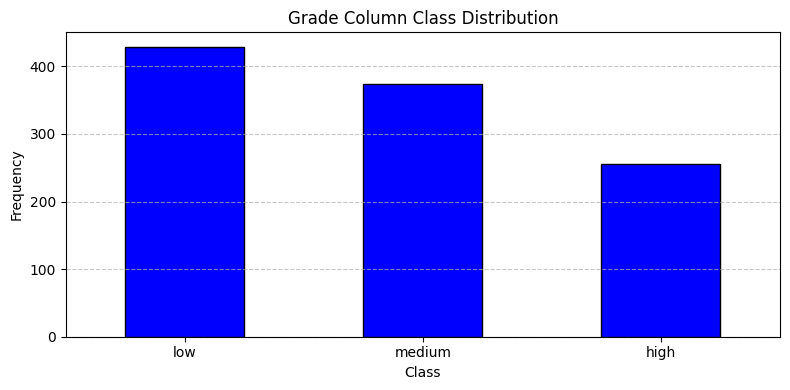

In [11]:
grade_counts = df['Grade'].value_counts()
grade_percent = df['Grade'].value_counts(normalize=True) * 100
grade_summary = pd.DataFrame({
    'Adet': grade_counts,
    'Yüzde (%)': grade_percent.round(2)
})

print(f"{grade_summary} \n")

grade_counts = df['Grade'].value_counts()

plt.figure(figsize=(8, 4))
grade_counts.plot(kind='bar', color='blue', edgecolor='black')
plt.title('Grade Column Class Distribution')
plt.xlabel('Class')
plt.ylabel('Frequency')
plt.xticks(rotation=0)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


In [12]:
# Her bir satırın kaç kez tekrar ettiğini sayalım
df['count'] = df.groupby(df.columns.tolist()).transform('size')

# Tekrar sıklığına göre ağırlıkları hesaplayalım
df['weight'] = 1 / df['count']

# Mükerrer verileri görüntüleyelim (count > 1 olanlar)
repeated_data = df[df['count'] > 1]

# Tekrar eden verilerin türlerini (benzersiz satırları) görüntüleyelim
unique_repeated_types = repeated_data.drop_duplicates(subset=df.columns.tolist())

# Sonuçları gösterelim
print(f"Mükerrer satır sayısı: {len(repeated_data)}")  # Mükerrer olan satırların toplam sayısını yazdırıyoruz
print(f"Benzersiz tekrar eden veri türü sayısı: {len(unique_repeated_types)} veri tekrar etmiş. \n")  # Tekrar eden benzersiz veri türlerini yazdırıyoruz

# Mükerrer verilerle birlikte count ve weight değerlerini gösterelim
print(" Repeated Rows:")
print(repeated_data[['count', 'weight']])

# İlk birkaç satırı ağırlıklarla birlikte gösterelim
print("\n\n First few rows with weights:")
print(df[['count', 'weight']])

# Mükerrer satırları görüntüleyelim
print("\n\n Unique repeated types:")
print(unique_repeated_types)

# Mükerrer verilerin model doğruluğunu etkilememesi ve daha sağlıklı işlem yapabilmek için ağırlık ayarlanır.

Mükerrer satır sayısı: 1038
Benzersiz tekrar eden veri türü sayısı: 62 veri tekrar etmiş. 

 Repeated Rows:
      count    weight
3        24  0.041667
5        22  0.045455
6        23  0.043478
7        18  0.055556
8        24  0.041667
...     ...       ...
1054     24  0.041667
1055     25  0.040000
1056     51  0.019608
1057      5  0.200000
1058     35  0.028571

[1038 rows x 2 columns]


 First few rows with weights:
      count    weight
0         1  1.000000
1         1  1.000000
2         1  1.000000
3        24  0.041667
4         1  1.000000
...     ...       ...
1054     24  0.041667
1055     25  0.040000
1056     51  0.019608
1057      5  0.200000
1058     35  0.028571

[1059 rows x 2 columns]


 Unique repeated types:
      pH  Temprature  Taste  Odor  Fat   Turbidity  Colour   Grade  count  \
3    9.5          34      1     1     0          1     255     low     24   
5    6.6          37      1     1     1          1     255    high     22   
6    5.5          45     

### Mükerrer Verilerin Etkisi
Mükerrer satır sayısı 1038'dir, yani veri setinizde 1000'den fazla satır başka satırların tam kopyasıdır. 
Bu durum, modelin aşırı temsil edilen örnekler üzerinde bias yapmasına neden olabilir.
Benzersiz tekrar eden veri türü sayısı ise 62'dir, yani bu 1038 satır yalnızca 62 benzersiz satır deseninden geliyor. 
Bu, belirli veri türlerinde yüksek bir tekrar yoğunluğu olduğunu gösteriyor.

### Ağırlıkların Analizi
Ağırlıkları, frekansa ters orantılı olarak doğru bir şekilde hesapladık:
 - 24 kez tekrar eden bir satırın ağırlığı ~0.0417'dir.
 - Sadece bir kez tekrar eden bir satırın ağırlığı 1.0'dır.
 - Daha az sık tekrar eden satırlar, daha fazla tekrar edenlere kıyasla daha yüksek ağırlıklar alır, 
   bu da etkiyi dengeler.

### Bu ağırlıklandırma sonucunda şu çıkarımları yapabiliriz:
 - Yaygın (tekrar eden) desenlerin eğitimi domine etmemesini sağlar.
 - Nadiren karşılaşılan (tekrar edilmeyen) desenlerin tam etkiye sahip kalmasını sağlar.
 - Genel olarak, modeliniz daha temsil edici bir öğrenme deneyimi elde eder ve daha iyi genelleme yapar.

Sonuç olarak, bu ağırlıklandırma yöntemini ANN modeliniz için mükemmel bir şekilde uyguladık:
 Bu yaklaşım, özellikle sınıflandırma görevlerinde oldukça uygundur, çünkü verileri silmek sınıf dengesizliğine 
 veya anlamlı kenar vakalarının kaybına neden olabilir.

In [13]:
# Ağırlıkların frekans tablosunu oluşturalım
weight_freq_table = df['weight'].value_counts().sort_index() #her bir ağırlığın kaç kez geçtiğini hesaplayıp küçükten büyüğe sıralyalım

weight_freq_df = weight_freq_table.reset_index()
weight_freq_df.columns = ['Weight', 'Frequency']
weight_freq_df

,Weight,Frequency
0,0.019608,51
1,0.026316,38
2,0.028571,35
3,0.029412,34
4,0.030303,33
5,0.034483,29
6,0.037037,54
7,0.040000,25
8,0.041667,96
9,0.043478,69


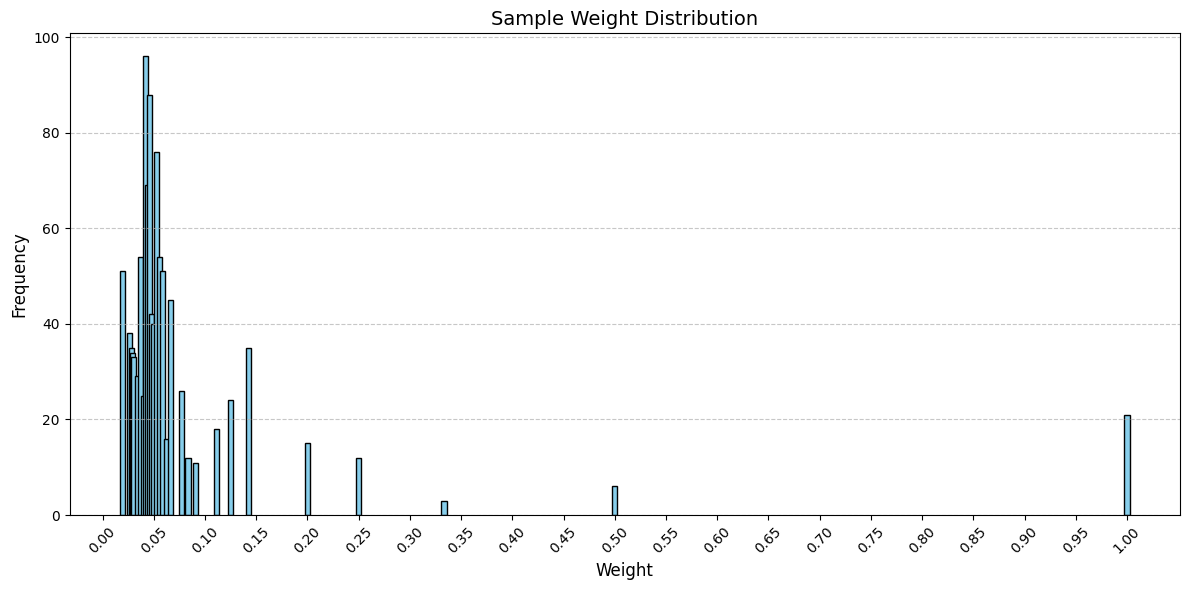

In [14]:
#Frekansını bulduğumuz ağırlıkların grafiğini çizdirip dağılımını inceleyelim.
plt.figure(figsize=(12, 6))
plt.bar(weight_freq_df['Weight'], weight_freq_df['Frequency'], width=0.005, color='skyblue', edgecolor='black')
xticks = np.arange(0, 1.05, 0.05)
plt.xticks(xticks, rotation=45) 
plt.title('Sample Weight Distribution', fontsize=14)
plt.xlabel('Weight', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

Mükerrer verilerin modeli yanlış yönlendirmemesi için oluşturduğumuz ağırlıkların dağılımını gözlemliyoruz. Ağırlıklar belirli bir aralıkta yoğunlaşmış ve dengeli bir dağılıma sahip değiller bu model için olumsuz bir durumdur ve model eğitilirken hesapladığımız bu ağırlıklar göz önünde bulundurulmalıdır.

In [15]:
df.head() #mükerrer veri tespiti sonucunda elde ettiğimiz count ve weight sütunlarının da dahil olduğu dataframe'i inceleyelim

,pH,Temprature,Taste,Odor,Fat,Turbidity,Colour,Grade,count,weight
0,6.6,35,1,0,1,0,254,high,1,1.000000
1,6.6,36,0,1,0,1,253,high,1,1.000000
2,8.5,70,1,1,1,1,246,low,1,1.000000
3,9.5,34,1,1,0,1,255,low,24,0.041667
4,6.6,37,0,0,0,0,255,medium,1,1.000000



* Bu çıktıyı incelediğimizde 0 numaralı index'te yer alan verinin(satırın) unique olduğu ve bu yüzden weight: 1.00 değerini aldığını gözlemliyoruz.
* Aynı şekilde 3 numaralı index incelendiğinde bu verinin(satırın) mükerrer olduğu ve bu yüzden weight: 0.04 değerini aldığını gözlemliyoruz.


# 3. Data Preprocessing

## 3.1. Data Preparation 
Features - target sütunları ayrılır, model eğitiminde kullanılmak üzere weights değerleri de saklanır.

In [16]:
X = df.drop(['Grade', 'count', 'weight'], axis=1) 
# features - count ve weight sütunlarını sonradan eklediğimiz için ve verinin öğrenmesine bir etkisi olmadığı için Grade sütununun yanında onları da çıkaralım

y = df['Grade'] 
# target - hedef değişkenimiz Grade

weights = df['weight'] 
# mükerrer verilerin modeli olumsuz etkilememesi için hesapladığımız değerleri de bir değişkene atayıp model eğitiminde kullanalım.

print(f"Features Columns: \n{X.head()}\n\nTarget Column:\n{y.head()}")

Features Columns: 
    pH  Temprature  Taste  Odor  Fat   Turbidity  Colour
0  6.6          35      1     0     1          0     254
1  6.6          36      0     1     0          1     253
2  8.5          70      1     1     1          1     246
3  9.5          34      1     1     0          1     255
4  6.6          37      0     0     0          0     255

Target Column:
0      high
1      high
2       low
3       low
4    medium
Name: Grade, dtype: object


## 3.2. Encoding Categorical Variables

Target sütunu (y) kategorik verilerden oluştuğu için bunları numerik verilere dönüştürmemiz gerekir. Bunu yapmanın en bilindik iki yöntemi vardır: Label Encoder(LE) ve One Hot Encoder(OHE). LE, kategorik ve sıralı verilerin encoding işleminde kullanılır; OHE, kategorik ve sırasız birbirine karşı üstünlüğü olmayan verilerin encoding işleminde kullanılır.



In [17]:
label_encoder = LabelEncoder() 
y_encoded = label_encoder.fit_transform(y)

y_ohe = to_categorical(y_encoded)
y = pd.DataFrame(y_ohe, columns=label_encoder.classes_)
y.head()

,high,low,medium
0,1.0,0.0,0.0
1,1.0,0.0,0.0
2,0.0,1.0,0.0
3,0.0,1.0,0.0
4,0.0,0.0,1.0


- Hedef değişkenimizdeki sınıf etiketleri string formatta olduğu için doğrudan one-hot encoding yapılamaz. Bu sebeple önce LabelEncoder ile bu string sınıf etiketlerini sayısal değerlere çeviriyoruz. Ardından to_categorical ile bu sayısal etiketleri one-hot encoding formatına dönüştürüyoruz.
- Bu iki adım sayesinde hedef değişkenimiz, softmax aktivasyon fonksiyonu ve categorical_crossentropy kaybı ile uyumlu hale gelir. Ayrıca LabelEncoder ile sınıf adları ile sayısal etiketleri eşleştirebildiğimiz için model çıktılarını anlamlandırmak kolaylaşır. Dataframe çıktısında encoding işlemi sonrasında yeni değerleri görmekteyiz.
    
    * high: 1.0 & low: 0.0 & medium: 0.0  -> High
    * high: 0.0 & low: 1.0 & medium: 0.0  -> Low
    * high: 0.0 & low: 0.0 & medium: 1.0  -> Medium

## 3.3. Weight Calculation
Hem veri tekrarlarını hem de sınıf dengesizliğini ölçebilmek için her örneğe bir final sample weight hesaplanmıştır. Bu ağırlık, iki bileşenin çarpımıdır, bu şekilde model hem tekrarlayan verilerden gelen yanlılığı azaltır hem de dengesiz sınıflar arasında daha sağlıklı bir öğrenme sağlar.
- weight: Veri setinde aynı örneklerin (duplicate) tekrar edilmesini dengelemek için önceden atanmış ağırlıklardır.
- class_weight: Dengesiz sınıf dağılımını dengelemek için, her sınıfa ters orantılı olarak ağırlık verilmiştir, *compute_class_weight* ile hesaplanmıştır.


In [18]:
# Sınıflar arası dengesizlikleri dengelemek için her sınıf için ağırlık hesaplanır 'balanced' parametresi, nadir sınıflara daha yüksek ağırlık verir.
class_weights_array = compute_class_weight(class_weight='balanced', classes=np.unique(y_encoded), y=y_encoded)
class_weight_dict = dict(enumerate(class_weights_array))

# tekrar eden örnek ağırlıkları alınır
weights = df['weight'].values

# Her örnek için final ağırlık: örnek ağırlığı × sınıf ağırlığı şeklinde hesaplanır.
final_weights = np.array([weights[i] * class_weight_dict[y_encoded[i]] for i in range(len(weights))])
final_weights

array([1.37890625, 1.37890625, 0.82284382, ..., 0.01613419, 0.27578125,
       0.02350982])

## 3.4. Data Standardization
 Özellikleri normalize etmek için StandardScaler tercih edildi. Bu işlem her özelliği ortalaması 0, standart sapması 1 olacak şekilde ölçeklendirir. Yapay sinir ağları gibi ağırlık tabanlı modellerde eğitim sürecini iyileştirmede önemli bir etkendir.

In [19]:
scaler = StandardScaler()
X = pd.DataFrame(scaler.fit_transform(X), columns=X.columns)
X.head()

,pH,Temprature,Taste,Odor,Fat,Turbidity,Colour
0,-0.021531,-0.914107,0.910503,-0.872962,0.699608,-0.982217,0.501600
1,-0.021531,-0.815035,-1.098294,1.145525,-1.429372,1.018105,0.269333
2,1.336564,2.553438,0.910503,1.145525,0.699608,1.018105,-1.356536
3,2.051351,-1.013180,0.910503,1.145525,-1.429372,1.018105,0.733867
4,-0.021531,-0.715962,-1.098294,-0.872962,-1.429372,-0.982217,0.733867


## 3.5. Data Splitting
Modelde kullanmak için train-test split işlemlerini gerçekleştirelim.

In [20]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [21]:
final_weights = final_weights[:len(X_train)] 
final_weights
# final_weights tüm veriyi içeriyordu, ancak modelin eğitimine sadece X_train kadar veriye ihtiyacımız var bu yüzden yalnızca eğitim verisi kadar uzunlukla sınırlandırıldı

array([1.37890625, 1.37890625, 0.82284382, 0.03428516, 0.94385027,
       0.06267756, 0.03577582, 0.04571355, 0.03428516, 0.03932709,
       0.04967633, 0.04330757, 0.02350982, 0.04840258, 0.04055607,
       0.03495742, 0.04114219, 0.01613419, 0.02165378, 0.02860152,
       0.0656622 , 0.03495742, 0.04330757, 1.37890625, 0.94385027,
       1.37890625, 0.03918304, 0.94385027, 0.07260387, 0.08618164,
       0.94385027, 0.82284382, 1.37890625, 0.13483575, 0.11754912,
       0.04055607, 0.16456876, 0.03740199, 0.13483575, 0.05995245,
       0.13483575, 0.04330757, 0.03577582, 0.08111213, 0.08580457,
       0.0555206 , 0.03932709, 0.0766059 , 0.03428516, 0.03254656,
       0.06267756, 0.03577582, 0.04571355, 0.03428516, 0.03932709,
       0.04967633, 0.04330757, 0.02350982, 0.04840258, 0.11798128,
       0.04290228, 0.05515625, 0.01613419, 0.02165378, 0.02350982,
       0.05243613, 0.04055607, 0.03495742, 0.04114219, 0.01613419,
       0.02165378, 0.02860152, 0.0656622 , 0.03495742, 0.04330

In [22]:
# Üzerinde işlem yapacağımız dataframelerin boyutlarını kontrol edelim 
print(f"X_train shape: {X_train.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"final_weights shape: {final_weights.shape}")

X_train shape: (741, 7)
y_train shape: (741, 3)
final_weights shape: (741,)


# 4. ANN Model

## 4.1. Model Architecture

In [23]:
input_layer = Input(shape=(X.shape[1],))
dense1 = Dense(64, activation='relu')(input_layer)
dropout1 = Dropout(0.05)(dense1)
dense2 = Dense(64, activation='relu')(dropout1) 
dense3 = Dense(32, activation='relu')(dense2) 
output = Dense(3, activation='softmax')(dense3) 

model = Model(inputs=input_layer, outputs=output) 
 
optimizer = Adam(learning_rate=0.0005) 
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy']) 

callbacks = [
    EarlyStopping(patience=5, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6)
]
history = model.fit(X_train, y_train, 
                    validation_split=0.2, epochs=50, batch_size=32,
                    sample_weight=final_weights,
                    callbacks=callbacks)

loss, accuracy = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {accuracy:.4f}")

I0000 00:00:1746652962.700058   41547 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1746652962.700835   41547 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


Epoch 1/50


I0000 00:00:1746652965.524157   41599 service.cc:148] XLA service 0x7d72cc005490 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1746652965.524191   41599 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1746652965.524198   41599 service.cc:156]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1746652965.705958   41599 cuda_dnn.cc:529] Loaded cuDNN version 90300


 1/19 ━━━━━━━━━━━━━━━━━━━━ 1:00 3s/step - accuracy: 0.2812 - loss: 0.1297

I0000 00:00:1746652966.930062   41599 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


19/19 ━━━━━━━━━━━━━━━━━━━━ 5s 112ms/step - accuracy: 0.2565 - loss: 0.1153 - val_accuracy: 0.4832 - val_loss: 0.0625 - learning_rate: 5.0000e-04
Epoch 2/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.4954 - loss: 0.0831 - val_accuracy: 0.6309 - val_loss: 0.0571 - learning_rate: 5.0000e-04
Epoch 3/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6399 - loss: 0.0804 - val_accuracy: 0.6779 - val_loss: 0.0524 - learning_rate: 5.0000e-04
Epoch 4/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7367 - loss: 0.0657 - val_accuracy: 0.7248 - val_loss: 0.0477 - learning_rate: 5.0000e-04
Epoch 5/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7688 - loss: 0.0632 - val_accuracy: 0.7248 - val_loss: 0.0434 - learning_rate: 5.0000e-04
Epoch 6/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8040 - loss: 0.0574 - val_accuracy: 0.7383 - val_loss: 0.0386 - learning_rate: 5.0000e-04
Epoch 7/50
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7949 - loss: 0.0466 -

### Katmanlar:
* Modelde üç adet katman vardır. Katman boyutları sırasıyla 64-64-32 olarak seçilmiştir.
* İlk katmandaki 64 nöron, giriş verisinin yüksek düzeyde temsil edilmesini sağlar.
* Orta katmandaki 64 nöron, öğrenilen özelliklerin daha zengin hale gelmesini sağlar.
* Son katmandaki 32 nöron, modelin daha kompakt bir temsile geçmesini sağlar.
Daha düşük nöron sayılarında (örneğin 16-32-32) model yeterli öğrenememiştir.64-32-16, 128-64-32, 32-32-16 gibi bazı yapılarla da denendi ancak en optimum sonuç 64-64-32 nöron sayılarıyla elde edildi. Epoch sayısı ise 50-100-150 olarak modelde test edildi, elimizdeki veriseti çok büyük olmadığı için en optimize sonucu 50 epoch vermiştir.

### Aktivasyon Fonksiyonu:
* ReLU (Rectified Linear Unit) aktivasyonu, doğrusal olmayanlık kazandırmak için kullanılmıştır. ReLU hızlı ve verimli çalışır, ancak negatif girişlerde sıfır döndürmesi bazı durumlarda bilgi kaybına neden olabilir. Alternatif olarak LeakyReLU denendi, ancak şu anki veri boyutu ve sonuçlara göre ReLU yeterli performansı sağlayamamıştır.

### Dropout:
İki Gizli (Dense) katmandan sonra %5 oranında dropout uygulanmıştır. Bu oran oldukça düşük bir regularization sağlar. Veri seti küçük olduğu için bu oran tercih edilmiştir. Eğer overfitting (aşırı öğrenme) belirgin olsaydı, dropout oranı 0.2–0.5 gibi daha yüksek değerlerle denenebilirdi ancak mevcut validation loss ve accuracy değerleri göz önüne alındığında bu oran şu an için yeterlidir.

### Öğrenme Oranı (Learning Rate):
Adam optimizer kullanılarak learning_rate=0.0005 olarak belirlenmiştir. Bu değer, modelin istikrarlı ve yavaş öğrenmesini sağlar. Daha yüksek bir oran (örneğin 0.1) daha hızlı ama dengesiz öğrenmeye neden olabilir. Daha düşük oranlar ise convergence süresini uzatabilir veya model hiç öğrenemeyebilir 0.0005 oranı bu yapı için uygun bir başlangıç noktasıdır.

### EarlyStopping:
patience=5 olarak belirlenmiştir, yani validation kaybı 5 epoch boyunca iyileşmezse eğitim durur. restore_best_weights=True ile, eğitim sonunda en iyi validation sonucuna sahip ağırlıklar geri yüklenir. Bu mekanizma, modelin aşırı öğrenmesini (overfitting) engeller ve eğitimi gereksiz yere uzatmaktan kaçınır.

### ReduceLROnPlateau:
validation loss 5 epoch boyunca iyileşmezse learning rate yarıya düşürülür (factor=0.5) min_lr=1e-6 sınırı ile, öğrenme oranının aşırı düşüp modelin tamamen durması engellenir.
Bu dinamik ayar sayesinde model, takıldığı yerlerde daha küçük adımlarla optimize olmayı sürdürebilir.

### sample_weight:
Veri setinde hem sınıf dengesizliği hem de mükerrer veriler bulunduğu için her örneğe ağırlık atayarak modelin daha adil ve dengeli öğrenmesi sağlanmıştır. Bu, özellikle nadir sınıfların öğrenilmesini kolaylaştırır.


## 4.2. Model Performance

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step

                        Classification Report                         

              precision    recall  f1-score   support

           0       0.87      0.89      0.88        76
           1       1.00      0.98      0.99       115
           2       0.93      0.93      0.93       127

    accuracy                           0.94       318
   macro avg       0.93      0.94      0.93       318
weighted avg       0.94      0.94      0.94       318

ROC AUC Score: 0.9959



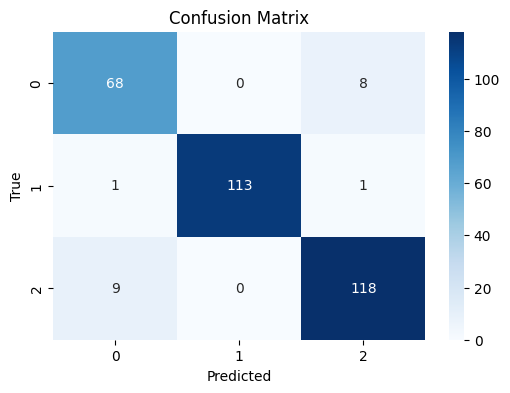

In [24]:
y_pred_probs = model.predict(X_test)
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = np.argmax(y_test, axis=1)

print(f"\n{'Classification Report'.center(70)}\n")

print(classification_report(y_true, y_pred))
roc_auc = roc_auc_score(y_test, y_pred_probs, multi_class='ovr')
print(f"ROC AUC Score: {roc_auc:.4f}\n")
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

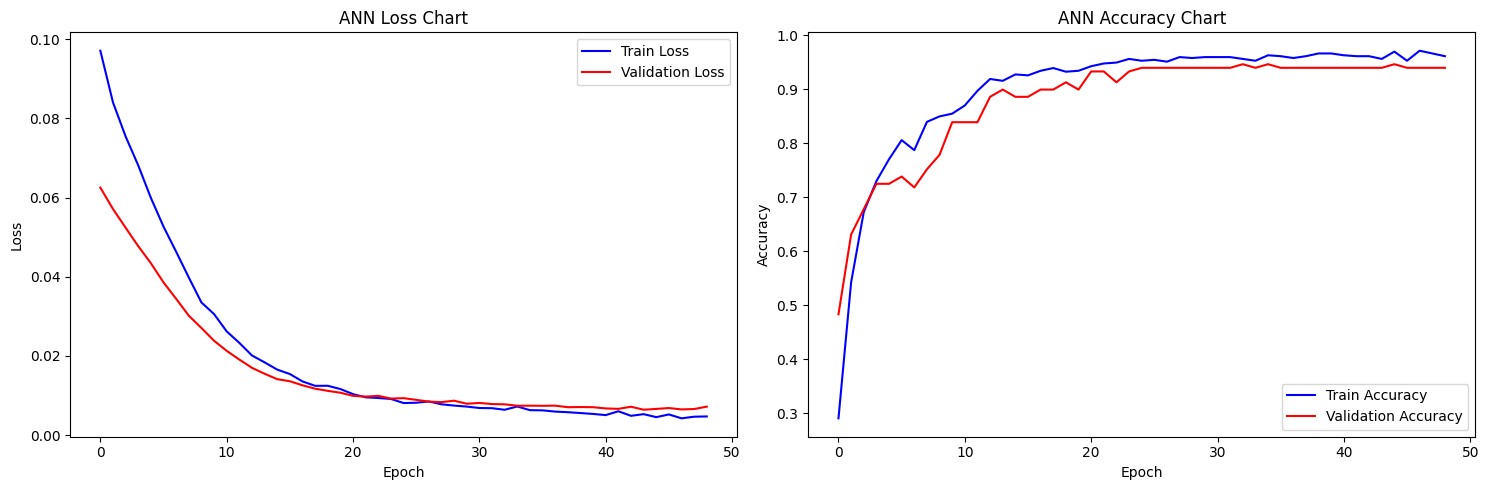

In [25]:
plt.figure(figsize=(15, 5))

# Accuracy grafiği
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Train Accuracy', color='blue')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy', color='red')
plt.title('ANN Accuracy Chart')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Loss grafiği
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss', color='blue')
plt.plot(history.history['val_loss'], label='Validation Loss', color='red')
plt.title('ANN Loss Chart')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

In [26]:
#Modeli kaydetme
model.save('ann_milk_quality_model.h5')

# 5. Genel Değerlendirme
Model validation accuracy değeri belirli bir noktadan sonra plato yapıyor bu, modelin veriden alabileceği maksimum verimi aldığını ve mimarinin veri setine göre sınırlarına ulaştığını göstermektedir. Mevcut modelin veri boyutuna ve problem yapısına göre başarılı bir sonuç verdiği gözlemlenmektedir.

Modelin **Precision**, **Recall**, **F1-Score** ve **Support** değerleri her bir sınıf için hesaplanmıştır. Bu metrikler, modelin her sınıfı ne kadar doğru tahmin ettiğini ve hangi sınıfların daha zor tahmin edildiğini gösterir:

- **Precision**: Modelin doğru sınıflandırdığı örneklerin, o sınıfa ait tüm tahminlere oranıdır. Yüksek precision, yanlış pozitiflerin düşük olduğunu gösterir. Sınıf 1, %100 precision ile en iyi performansı göstermektedir.
- **Recall**: Modelin doğru tahmin ettiği örneklerin, o sınıfın toplam örneklerine oranıdır. Yüksek recall, yanlış negatiflerin düşük olduğunu gösterir. Sınıf 1, %98 recall ile en iyi performansı göstermektedir.
- **F1-Score**: Precision ve recall'un dengeli bir şekilde birleşimi olan F1 skoru, modelin genel performansını temsil eder. Sınıf 1 ve sınıf 2, sırasıyla 0.99 ve 0.93 ile oldukça iyi bir F1-Score'a sahiptir.

#### Genel Doğruluk (Accuracy)
Modelin **genel doğruluğu**: `0.94` olarak hesaplanmıştır. Bu, modelin test verisinin %97'sini doğru tahmin ettiğini gösteriyor, yani model oldukça başarılı.

#### Macro ve Weighted Average
- **Macro Average**: Tüm sınıfların ortalama performansını gösterir. Model, tüm sınıflarda yüksek precision, recall ve F1-Score değerlerine sahip.
- **Weighted Average**: Her sınıfın örnek sayısına göre ağırlıklı ortalama hesaplanmıştır. Burada da modelin geneli üzerinde başarılı sonuçlar elde edilmiştir.

#### ROC AUC Skoru
Modelin **ROC AUC skoru**: `0.9959` olarak hesaplanmıştır. Bu skor, modelin sınıfları ayırt etme yeteneğinin çok güçlü olduğunu ve doğru sınıflandırma yapma konusunda yüksek bir başarı gösterdiğini işaret eder.

Bu sonuçlar, modelin **yüksek doğruluk oranı** ve **dengeli performansı** ile **genel olarak güçlü bir sınıflandırma yeteneğine** sahip olduğunu göstermektedir. Modelin her bir sınıfta da iyi sonuçlar verdiği ve özellikle **Sınıf 1 ve Sınıf 2'nin yüksek recall ve precision değerlerine sahip olduğu** gözlemlenmektedir. 